### <center> Домашнее задание к лекции 2

1. Самостоятельно разобраться с тем, что такое tfidf (документация https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html и еще - https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)
2. Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)
3. Повторить п.2, но используя уже не медиану, а max
4. (опциональное, если очень хочется) Воспользовавшись полученными знаниями из п.1, повторить пункт 2, но уже взвешивая новости по tfidf (подсказка: нужно получить веса-коэффициенты для каждого документа. Не все документы одинаково информативны и несут какой-то положительный сигнал). Подсказка 2 - нужен именно idf, как вес.
5. Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score
6. Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных

#### Подготовка кода для ДЗ  

---

In [1]:
import pandas as pd

In [2]:
news = pd.read_csv("../lection2_materials/articles.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


In [4]:
users = pd.read_csv("../lection2_materials/users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


### 1. Получаем векторные представления новостей

In [7]:
#!pip install gensim
#!pip install python-Levenshtein

  Using cached python-Levenshtein-0.12.2.tar.gz (50 kB)
  Running setup.py clean for python-Levenshtein
Failed to build python-Levenshtein
    Running setup.py install for python-Levenshtein: started
    Running setup.py install for python-Levenshtein: finished with status 'error'


  ERROR: Command errored out with exit status 1:
   command: 'D:\ProgramData\Anaconda3\envs\GPUenv\python.exe' -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\asavv\\AppData\\Local\\Temp\\pip-install-humunhac\\python-levenshtein_1d687a5a7f19428ba96089b71870bef6\\setup.py'"'"'; __file__='"'"'C:\\Users\\asavv\\AppData\\Local\\Temp\\pip-install-humunhac\\python-levenshtein_1d687a5a7f19428ba96089b71870bef6\\setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d 'C:\Users\asavv\AppData\Local\Temp\pip-wheel-4fm72z28'
       cwd: C:\Users\asavv\AppData\Local\Temp\pip-install-humunhac\python-levenshtein_1d687a5a7f19428ba96089b71870bef6\
  Complete output (27 lines):
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build\lib.win-amd64-3.8
  creating build\lib.win-amd64-3.8\Levenshtein
  copying Levenshte

In [8]:
from gensim.corpora.dictionary import Dictionary

In [9]:
#!pip install razdel

In [10]:
#!pip install pymorphy2

In [11]:
#предобработка текстов
import re
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from razdel import tokenize # https://github.com/natasha/razdel


import pymorphy2

In [12]:
stopword_ru = stopwords.words('russian')
len(stopword_ru)

morph = pymorphy2.MorphAnalyzer()

In [14]:
with open('../lection2_materials/stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [16]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [17]:
%%time
#Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

<ipython-input-16-7ee348d9b386>:15: FutureWarning: Possible nested set at position 39
  text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)


Wall time: 25 s


In [18]:
%%time
#Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

Wall time: 3min 12s


In [19]:
news['title']

0        [заместитель, председатель, правительство, рф,...
1        [матч, финал, кубок, россия, футбол, приостано...
2        [форвард, авангард, томаш, заборский, прокомме...
3        [главный, тренер, кубань, юрий, красножанин, п...
4        [решение, попечительский, совет, владивостокск...
                               ...                        
26995    [учёный, токийский, университет, морской, наук...
26996    [глава, кафедра, отечественный, история, xx, в...
26997    [американский, учёный, уточнить, возраст, расп...
26998    [последний, год, тропический, углеродный, цикл...
26999    [жить, примерно, тыс, год, назад, территория, ...
Name: title, Length: 27000, dtype: object

In [20]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

In [21]:
from gensim.models import LdaModel

In [22]:
%%time
from gensim.models import LdaModel
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary)#, passes=10)

Wall time: 33.6 s


In [23]:
from gensim.test.utils import datapath
# Save model to disk.
temp_file = datapath("model.lda")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

In [24]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'свой', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'nnnn', 'провести', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'работа', 'сказать', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'мочь', 'играть', 'ещё', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'это', 'хороший']


[(6, 0.13605033),
 (7, 0.20439847),
 (9, 0.0548275),
 (10, 0.22054748),
 (14, 0.20260961),
 (23, 0.1648212)]

In [25]:
x=lda.show_topics(num_topics=25, num_words=7,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: банк это год ставка цена который расчёт
topic_1: газ млрд турция инвестиция налог конкурс супруг
topic_2: женщина мужчина nn фестиваль век год мероприятие
topic_3: мышь бомба калининградский новосибирский летучий велосипед смех
topic_4: это который год новый исследование проект мочь
topic_5: год это компания мочь который рост цена
topic_6: это человек который свой статья всё мочь
topic_7: италия год испания nn обнаружить лондон диапазон
topic_8: топливо снизиться дональд турецкий физика небо прогнозировать
topic_9: виза студия гагарин писать сезон кольцо вена
topic_10: общество двигатель поиск знаменитый вероятно погода ночью
topic_11: год который это военный время свой наука
topic_12: рак японский золото таиланд музыка ми ким
topic_13: смерть космос планета опрос майкл принадлежащий звёздный
topic_14: россия российский президент nn страна год это
topic_15: ребёнок помощь год человек агентство страдать семья
topic_16: млрд тыс год ребёнок долг увеличение объём
topic_17: продук

In [26]:
#text = news['title'].iloc[0]

def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [27]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.569241,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,...,0.011568,0.215657,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0
1,4896,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.423182,0.0,...,0.000000,0.000000,0.0,0.553795,0.0,0.0,0.000000,0.0,0.000000,0.0
2,4897,0.000000,0.0,0.0,0.000000,0.0,0.0,0.136013,0.204390,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.164817,0.0
3,4898,0.729833,0.0,0.0,0.000000,0.0,0.0,0.181857,0.077803,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0
4,4899,0.000000,0.0,0.0,0.028597,0.0,0.0,0.000000,0.157191,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.204203,0.0,0.000000,0.0


### Следующий шаг - векторные представления пользователей

In [53]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [54]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

In [156]:
user_articles_list = users['articles'].iloc[33]

def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.mean(user_vector, 0)
    return user_vector

In [157]:
get_user_embedding(user_articles_list)

array([0.01972251, 0.        , 0.01092143, 0.        , 0.08067714,
       0.07275719, 0.13098253, 0.        , 0.        , 0.        ,
       0.        , 0.07591197, 0.        , 0.00766953, 0.31712215,
       0.01303511, 0.00963218, 0.01486263, 0.15948839, 0.05488849,
       0.        , 0.00946418, 0.        , 0.01012868, 0.        ])

In [57]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.017503,0.000000,0.063798,0.001913,0.073601,0.048849,0.121840,0.000000,0.000000,...,0.057748,0.066592,0.00000,0.108787,0.005012,0.0,0.080289,0.0,0.000000,0.063300
1,u108690,0.048450,0.000000,0.011981,0.000000,0.071485,0.040175,0.177130,0.006542,0.002048,...,0.016689,0.012273,0.00000,0.147308,0.034965,0.0,0.088655,0.0,0.000000,0.089240
2,u108339,0.058296,0.012068,0.035365,0.000000,0.035967,0.046621,0.069904,0.003451,0.000000,...,0.030509,0.018358,0.00666,0.244961,0.024222,0.0,0.088511,0.0,0.013117,0.083722


Датасет готов - можно попробовать обучить модель. Загрузим нашу разметку

In [34]:
target = pd.read_csv("../lection2_materials/users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [79]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.017503,0.000000,0.063798,0.001913,0.073601,0.048849,0.121840,0.000000,0.000000,...,0.066592,0.00000,0.108787,0.005012,0.0,0.080289,0.0,0.000000,0.063300,0
1,u108690,0.048450,0.000000,0.011981,0.000000,0.071485,0.040175,0.177130,0.006542,0.002048,...,0.012273,0.00000,0.147308,0.034965,0.0,0.088655,0.0,0.000000,0.089240,1
2,u108339,0.058296,0.012068,0.035365,0.000000,0.035967,0.046621,0.069904,0.003451,0.000000,...,0.018358,0.00666,0.244961,0.024222,0.0,0.088511,0.0,0.013117,0.083722,1


In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [80]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [81]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [82]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.23211889, 0.01229109, 0.58318606, 0.17576633, 0.01136667,
       0.06785437, 0.05795721, 0.05866049, 0.10763726, 0.11694921])

In [83]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

### Рассчитаем Precision, Recall, F_score

In [84]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.269111, F-Score=0.710, Precision=0.641, Recall=0.796


In [85]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1646  109]
 [  51  194]]


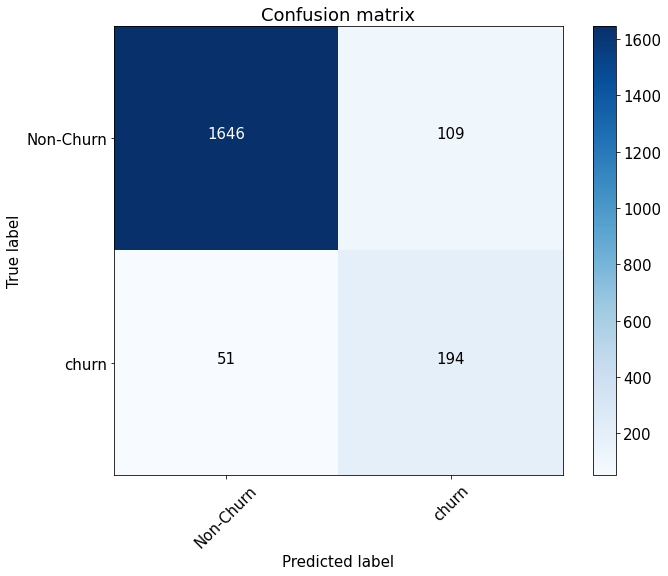

In [86]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [87]:
roc_auc_score(y_test, preds)

0.9558020815163671

**Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)**

---

In [88]:
def get_user_embedding_median(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.median(user_vector, 0)
    return user_vector

In [89]:
get_user_embedding_median(user_articles_list)

array([0.        , 0.        , 0.        , 0.        , 0.01529451,
       0.08816665, 0.08751796, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.27259744,
       0.        , 0.        , 0.        , 0.11415647, 0.01166375,
       0.        , 0.        , 0.        , 0.        , 0.        ])

In [90]:
user_embeddings1 = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_median(x), 1)])
user_embeddings1.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings1['uid'] = users['uid'].values
user_embeddings1 = user_embeddings1[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings1.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.000000,0.0,0.035458,0.0,0.000000,0.000000,0.101684,0.0,0.0,...,0.00000,0.035275,0.0,0.053168,0.000000,0.0,0.045920,0.0,0.0,0.000000
1,u108690,0.038181,0.0,0.016794,0.0,0.058970,0.031862,0.205159,0.0,0.0,...,0.00000,0.000000,0.0,0.147803,0.030256,0.0,0.068516,0.0,0.0,0.049151
2,u108339,0.047465,0.0,0.044356,0.0,0.033626,0.050224,0.079933,0.0,0.0,...,0.01809,0.015652,0.0,0.255671,0.027936,0.0,0.082728,0.0,0.0,0.064089


In [91]:
X1 = pd.merge(user_embeddings1, target, 'left')
X1.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.000000,0.0,0.035458,0.0,0.000000,0.000000,0.101684,0.0,0.0,...,0.035275,0.0,0.053168,0.000000,0.0,0.045920,0.0,0.0,0.000000,0
1,u108690,0.038181,0.0,0.016794,0.0,0.058970,0.031862,0.205159,0.0,0.0,...,0.000000,0.0,0.147803,0.030256,0.0,0.068516,0.0,0.0,0.049151,1
2,u108339,0.047465,0.0,0.044356,0.0,0.033626,0.050224,0.079933,0.0,0.0,...,0.015652,0.0,0.255671,0.027936,0.0,0.082728,0.0,0.0,0.064089,1


In [92]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1[['topic_{}'.format(i) for i in range(25)]], 
                                                    X1['churn'], random_state=0)

In [93]:
logreg1 = LogisticRegression()
#обучим 
logreg1.fit(X_train1, y_train1)

LogisticRegression()

In [94]:
#наши прогнозы для тестовой выборки
preds1 = logreg1.predict_proba(X_test1)[:, 1]
preds1[:10]

array([0.30727921, 0.06022856, 0.58783549, 0.28940015, 0.01417824,
       0.06947328, 0.06946375, 0.0466687 , 0.10043551, 0.25357337])

Перед расчетом метрик подготовим базу для таблицы сравнения метрик:

In [95]:
metric_list=[[i] for i in [thresholds[ix], fscore[ix], precision[ix], recall[ix]]]
metric_list

[[0.26911113663028596],
 [0.7103825136612021],
 [0.6414473684210527],
 [0.7959183673469388]]

In [96]:
precision, recall, thresholds = precision_recall_curve(y_test1, preds1)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.321068, F-Score=0.793, Precision=0.767, Recall=0.820


In [97]:
median_metrcs=[thresholds[ix], fscore[ix], precision[ix], recall[ix]]
for i in range(len(metric_list)):
    metric_list[i].append(median_metrcs[i])
metric_list

[[0.26911113663028596, 0.32106827066044946],
 [0.7103825136612021, 0.7928994082840237],
 [0.6414473684210527, 0.767175572519084],
 [0.7959183673469388, 0.8204081632653061]]

Confusion matrix, without normalization
[[1694   61]
 [  45  200]]


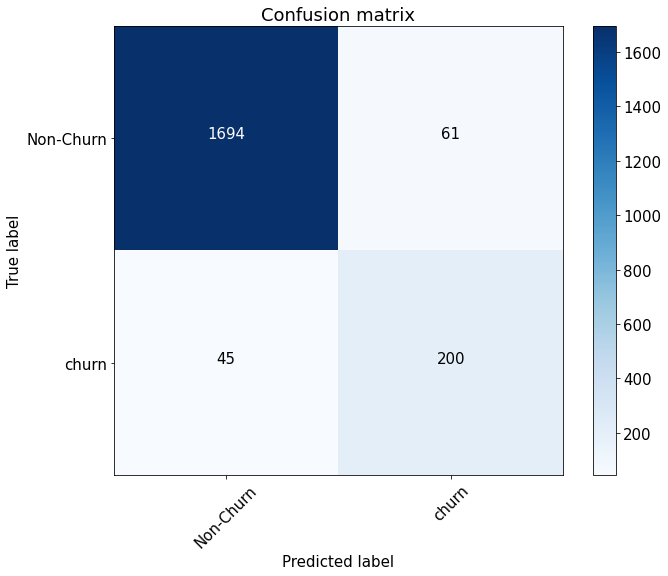

In [98]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test1, preds1>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [99]:
roc_auc_score(y_test1, preds1)

0.9789685446828305

**Повторим п.2, но используя уже не медиану, а max**  

---

In [100]:
def get_user_embedding_max(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.max(user_vector, 0)
    return user_vector

In [101]:
get_user_embedding_max(user_articles_list)

array([0.0736609 , 0.        , 0.06552859, 0.        , 0.41617844,
       0.13492249, 0.39176303, 0.        , 0.        , 0.        ,
       0.        , 0.2526198 , 0.        , 0.0460172 , 0.76711416,
       0.07821067, 0.05779307, 0.08917578, 0.49195665, 0.28160468,
       0.        , 0.03547133, 0.        , 0.06077209, 0.        ])

In [102]:
user_embeddings2 = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_max(x), 1)])
user_embeddings2.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings2['uid'] = users['uid'].values
user_embeddings2 = user_embeddings2[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings2.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.105017,0.00000,0.230874,0.011475,0.404722,0.154237,0.367249,0.000000,0.000000,...,0.305249,0.198577,0.000000,0.370814,0.030075,0.0,0.219487,0.0,0.000000,0.300411
1,u108690,0.129844,0.00000,0.019485,0.000000,0.174717,0.089103,0.291766,0.027746,0.012287,...,0.086191,0.058095,0.000000,0.400892,0.088643,0.0,0.205657,0.0,0.000000,0.278530
2,u108339,0.140793,0.07241,0.070046,0.000000,0.059096,0.090157,0.151698,0.020706,0.000000,...,0.090041,0.055409,0.039958,0.355384,0.050708,0.0,0.249860,0.0,0.056481,0.276341


In [103]:
X2 = pd.merge(user_embeddings2, target, 'left')
X2.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.105017,0.00000,0.230874,0.011475,0.404722,0.154237,0.367249,0.000000,0.000000,...,0.198577,0.000000,0.370814,0.030075,0.0,0.219487,0.0,0.000000,0.300411,0
1,u108690,0.129844,0.00000,0.019485,0.000000,0.174717,0.089103,0.291766,0.027746,0.012287,...,0.058095,0.000000,0.400892,0.088643,0.0,0.205657,0.0,0.000000,0.278530,1
2,u108339,0.140793,0.07241,0.070046,0.000000,0.059096,0.090157,0.151698,0.020706,0.000000,...,0.055409,0.039958,0.355384,0.050708,0.0,0.249860,0.0,0.056481,0.276341,1


In [104]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2[['topic_{}'.format(i) for i in range(25)]], 
                                                    X2['churn'], random_state=0)

In [105]:
logreg2 = LogisticRegression()
#обучим 
logreg2.fit(X_train2, y_train2)

LogisticRegression()

In [106]:
#наши прогнозы для тестовой выборки
preds2 = logreg2.predict_proba(X_test2)[:, 1]
preds2[:10]

array([0.20950983, 0.00505977, 0.86719402, 0.07850125, 0.07002954,
       0.03809532, 0.00630594, 0.01693129, 0.02140857, 0.06104286])

In [107]:
precision, recall, thresholds = precision_recall_curve(y_test2, preds2)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.334098, F-Score=0.745, Precision=0.698, Recall=0.800


In [108]:
median_metrcs=[thresholds[ix], fscore[ix], precision[ix], recall[ix]]
for i in range(len(metric_list)):
    metric_list[i].append(median_metrcs[i])
metric_list

[[0.26911113663028596, 0.32106827066044946, 0.334097659117281],
 [0.7103825136612021, 0.7928994082840237, 0.7452471482889734],
 [0.6414473684210527, 0.767175572519084, 0.697508896797153],
 [0.7959183673469388, 0.8204081632653061, 0.8]]

Confusion matrix, without normalization
[[1670   85]
 [  50  195]]


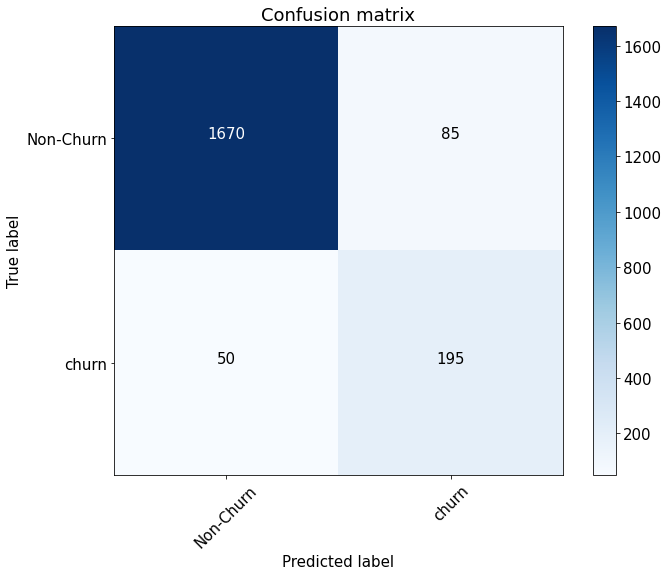

In [110]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test2, preds2>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [111]:
roc_auc_score(y_test2, preds2)

0.959811616954474

**Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score**  

---

In [118]:
metric_df=pd.DataFrame(
    metric_list, columns=['mean','median','max'], index=['Treshhold','F-score','Precision', 'Recall']
).append(pd.DataFrame(
                    [[roc_auc_score(y_test, preds),roc_auc_score(y_test1, preds1),roc_auc_score(y_test2, preds2)]],
    columns=['mean','median','max'],
    index=['ROC-AUC']))
metric_df

,mean,median,max
Treshhold,0.269111,0.321068,0.334098
F-score,0.710383,0.792899,0.745247
Precision,0.641447,0.767176,0.697509
Recall,0.795918,0.820408,0.800000
ROC-AUC,0.955802,0.978969,0.959812


Как видно из таблицы, наиболее эффективным оказался метод с использованием медианы для получения эмбеддинга пользователя, т.к. мы получаем более разреженный вектор заинтересованности пользователя, в следствии того, что что в отличии от среднего и максимального значения, медиана чаще будет равна нулю, на тех темах статей, оторые редко появляются в векторе статей читаемых пользователем. То есть интересы пользователя будут выражены наиболее явно.